In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import optax
from flax.training import train_state
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
#from soap_jax import soap

import jaxmetric as jm
import models

In [2]:
key = jax.random.PRNGKey(0)

psi=0

k_mod = [1]

proj_facts = (4,)

poly = jit(lambda x: x[0]**5 + x[1]**5 + x[2]**5 +x[3]**5 + x[4]**5 + psi* x[0]*x[1]*x[2]*x[3]*x[4])

# psi0 = 0.5
# psi1 = 1.


# import itertools
# combinations = list(itertools.product([0, 1], repeat=4))

# @jit
# def poly(x):
#     X = jnp.array([x[0],x[1]])
#     Y = jnp.array([x[2],x[3]])
#     U = jnp.array([x[4],x[5]])
#     V = jnp.array([x[6],x[7]])
#     term_sum = 0
#     term_prod = psi1 * (X[0] * Y[0] * U[0] * V[0]) * (X[1] * Y[1] * U[1] * V[1])
#     for c in combinations:
#         s = sum(c)
#         term_sum += (1-s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2. + psi0*(s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2.

#     return term_prod + term_sum

In [3]:
# points = jm.point_gen.generate_points_calabi_yau(key, proj_facts,poly,5e5)


# with open("500kPointsPsiEq0.pkl", "wb") as f:
#     pickle.dump(points, f)


with open("100kPointsPsiEq0.pkl", "rb") as f:
    points = pickle.load(f)


print(jnp.shape(points))

(100000, 5)


In [4]:
# Initialize the model
model = models.FuncQuintic()

# Generate a PRNG key
key = jax.random.PRNGKey(np.random.randint(0,10**6))

# Initialize parameters
params = model.init(key,  jm.complex_numbers.complex_to_real(points[0]))

kappa_val = jm.metrics.kappa(proj_facts,k_mod, poly, points)

print(kappa_val)

0.51561314


In [5]:
# Split points into training and evaluation sets
split_ratio = 0.8
split_index = int(len(points) * split_ratio)
train_points = points[:split_index]
eval_points = points[split_index:]

def batch_data(data, batch_size):
    num_batches = len(data) // batch_size
    return jnp.array_split(data[:num_batches * batch_size], num_batches)

ptsBatched = batch_data(train_points, 64)

print(ptsBatched[0].shape,len(ptsBatched))
print(eval_points[0].shape,len(eval_points))

(64, 5) 1250
(5,) 20000


In [6]:
scals = [jm.metrics.ricci_scalar(model, params, proj_facts, k_mod, poly, ptsBatched[n]).real for n in tqdm(range(100))]
scals = jnp.array(scals).flatten()

100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


(array([1.909e+03, 1.063e+03, 7.620e+02, 4.960e+02, 3.660e+02, 2.720e+02,
        2.270e+02, 1.990e+02, 1.500e+02, 1.220e+02, 1.020e+02, 1.020e+02,
        8.600e+01, 8.300e+01, 4.400e+01, 5.100e+01, 4.200e+01, 4.100e+01,
        3.800e+01, 3.700e+01, 3.000e+01, 2.400e+01, 1.700e+01, 1.900e+01,
        1.400e+01, 1.400e+01, 8.000e+00, 1.200e+01, 9.000e+00, 8.000e+00,
        6.000e+00, 6.000e+00, 1.100e+01, 5.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-12.12275982,  -5.25674248,   1.60927463,   8.47529221,
         15.34130859,  22.20732689,  29.07334328,  35.93936157,
         42.80537796,  49.67139435,  56.53741074,  63.40343094,
         70.26944733,  77.13546753,  84.0014801 ,  90.86750031,
         97.73351288, 104.59953308, 111.46555328, 118.33156586,
        125.19758606, 132.06359863, 138.92961121, 145.79

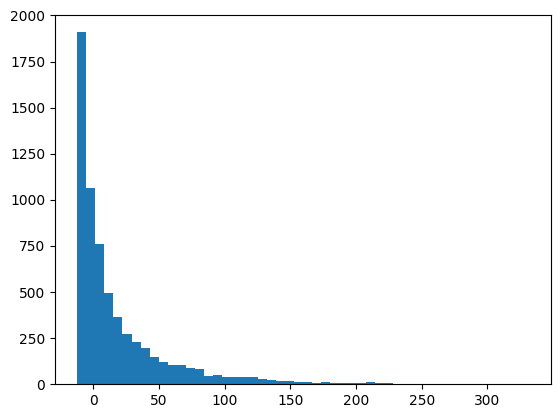

In [7]:
plt.hist(scals,bins=50)

In [8]:
def replace_nan_grads(gradients, replacement_value=1e-8):
    def replace(grad):
        return jnp.where(jnp.isnan(grad), replacement_value, grad)
    
    return jax.tree_util.tree_map(replace, gradients)

def nan_replacement_transform(replacement_value=1e-6):
    def init_fn(params):
        return ()
    
    def update_fn(updates, state, params=None):
        sanitized_updates = jax.tree_util.tree_map(
            lambda g: jnp.where(jnp.isnan(g), replacement_value, g),
            updates
        )
        return sanitized_updates, state
    
    return optax.GradientTransformation(init_fn, update_fn)

optimiser = optax.chain(
#optax.clip(1e-2),
#soap(learning_rate=1e-6),
#optax.clip_by_block_rms(1e-2),
optax.adam(learning_rate=1e-3),
#nan_replacement_transform(1e-8)
)

my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

grad_func = jax.jit(jax.value_and_grad(jm.losses.loss_ma,argnums=1),static_argnums=(0,2,4))

# Define the training step
@jax.jit
def train_step(state,x):
  loss, grads = grad_func(model, state.params,proj_facts,k_mod, poly,  kappa_val, x)
  state = state.apply_gradients(grads=grads)
  return state, loss

@jax.jit
def evaluate_step(state,x,scalar_num=100):
  loss = jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  sigma = jm.losses.sigma_measure(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  scalar =  jnp.mean(jnp.abs(jm.metrics.ricci_scalar(model, state.params, proj_facts, k_mod, poly, x[:scalar_num])))
  return loss, sigma, scalar

In [9]:
# Train the model
eval, sig, scal = evaluate_step(my_state,eval_points)
loss = []
lossEval = [[0,eval]]
sigma = [[0,sig]]
scalar = [[0,scal]]
pbar = tqdm(range(50))
batchNum = len(ptsBatched)
pbar.set_description(f"Last Eval Loss {eval} | Last Eval Sigma {sig} | Average Eval Scalar {scal}  | Batch {0}/{batchNum+1}  | Batch Loss: NA")

for i in pbar:
  order = np.array(range(batchNum))
  np.random.shuffle(order)
  k=1
  for j in order:
    k+=1
    my_state, l = train_step(my_state, ptsBatched[j])
    if k % 10 == 0:
      pbar.set_description(f"Last Eval Loss {eval} | Last Eval Sigma {sig} | Average Eval Scalar {scal} | Batch {k}/{batchNum+1}  | Batch Loss: {l}" )
    loss.append(l)
  eval, sig, scal = evaluate_step(my_state,eval_points)
  lossEval.append([(i+1)*batchNum,eval])
  sigma.append([(i+1)*batchNum,sig])
  scalar.append([(i+1)*batchNum,scal])

lossEval = np.array(lossEval)
loss = jnp.array(loss)

Last Eval Loss 0.25353682041168213 | Last Eval Sigma 0.34276244044303894 | Average Eval Scalar 16.779077529907227 | Batch 1250/1251  | Batch Loss: 0.20679454505443573: 100%|██████████| 50/50 [16:41<00:00, 20.03s/it]


In [10]:
lossEval=jnp.array(lossEval)
loss = jnp.array(loss)
sigma = jnp.array(sigma)
scalar = jnp.array(scalar)

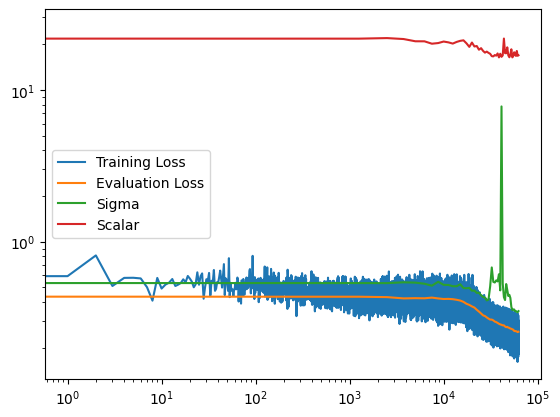

In [11]:
plt.plot(loss, label='Training Loss')
plt.plot(lossEval[:,0], lossEval[:,1], label='Evaluation Loss')
plt.plot(sigma[:,0], sigma[:,1], label='Sigma')
plt.plot(scalar[:,0], scalar[:,1], label='Scalar')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
scals = [jm.metrics.ricci_scalar(model, my_state.params, proj_facts, k_mod, poly, ptsBatched[n]).real for n in tqdm(range(100))]
scals = jnp.array(scals).flatten()

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


(array([2.740e+03, 2.932e+03, 5.850e+02, 1.130e+02, 1.800e+01, 7.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ -26.94852066,    3.79397035,   34.53646088,   65.27895355,
          96.02144623,  126.76393127,  157.50642395,  188.24891663,
         218.9914093 ,  249.73390198,  280.47637939,  311.21887207,
         341.96136475,  372.70385742,  403.4463501 ,  434.18884277,
         464.93133545,  495.67382812,  526.4163208 ,  557.15881348,
         587.90130615,  618.64379883

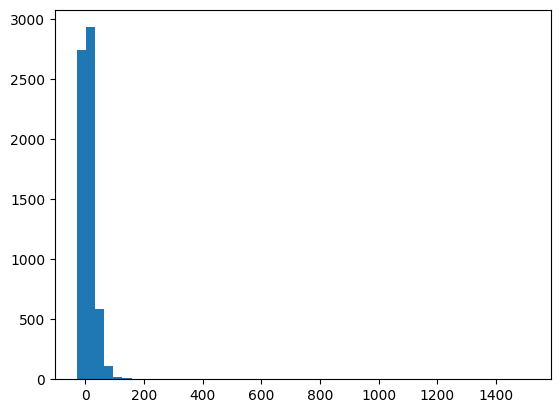

In [13]:
plt.hist(scals,bins=50)